Use fancy machine learning to predict whether an article makes it into Nature/Science or PRL. This time we'll only look at articles in the physics.atom-ph section.

In [82]:
#Need to add parent directoy to sys.path to find 'metadataDB'
import sys
sys.path.append('../../')

%matplotlib inline
import matplotlib.pyplot as plt 
import time
import numpy as np
import re
from itertools import combinations
import json

# Natural language processing toolkit
# To use this, run nltk.download() and download 'stopwords'
# from nltk.corpus import stopwords
# s=stopwords.words('english') + ['']

# Machine learning
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.cross_validation import train_test_split

# SQL
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from metadataDB.declareDatabase import *
from sqlalchemy import or_, and_

engine = create_engine("sqlite:///../../arXiv_metadata.db", echo=False)
Base.metadata.bind = engine
DBsession = sessionmaker(bind=engine)
session = DBsession()

In [65]:
categories = ['atom-ph', 'quant-ph', 'cond-mat', 'quant-gas', 'hep-th', 'hep-ex', '']
categories = ['quant-ph']
journals_dict = {'PRL': ['Physics Review Letters%',
                    'Phys. Rev. Lett.%',
                    'Phys.Rev.Lett.%',
                    'PRL%'],
                 'PR':  ['Physics Review%',
                         'Phys. Rev.%',
                         'Phys.Rev.%',
                         'PR%'],
                 'Nature': ['Nature%',
                            'Nat.%',
                            'Science%'],
                 'APL': ['APL%',
                         'Appl.Phys.Lett.%',
                         'Appl. Phys. Lett.%',
                         'Applied Physics Letters%'],
                 'AP': ['AP%',
                        'Appl.Phys.%',
                        'Appl. Phys.%',
                        'Applied Physics%'],
                 'All': ['%'],
                 }


In [73]:
def get_abstracts(journal, category):
    query = session.query(Article_Category)\
                    .join(Category)\
                    .join(Article)\
                    .filter(Category.name.like('%' + category + '%'),
                            or_(*[Article.journal_ref.like(x) for x in journals_dict[journal]]))

    # Don't need to clean up text: CountVectorizer will do everything
    return [ result.article.abstract for result in query ]


def learn(journals, category):
    abstracts1 = get_abstracts(journals[0], category)
    abstracts2 = get_abstracts(journals[1], category)
    
    half_test_size = int(round(0.2*min(len(abstracts1),len(abstracts2))))
#     print half_test_size

    X1_train, X1_test, y1_train, y1_test = train_test_split(abstracts1, [0]*len(abstracts1), test_size=half_test_size, random_state=42)
    X2_train, X2_test, y2_train, y2_test = train_test_split(abstracts2, [1]*len(abstracts2), test_size=half_test_size, random_state=42)

    X_train = X1_train + X2_train
    X_test = X1_test + X2_test
    y_train = np.array(y1_train + y2_train)
    y_test = np.array(y1_test + y2_test)
    target_names = journals
    
    
    clf = Pipeline([('vect', CountVectorizer(ngram_range=(1,3))),
                    ('tfidf', TfidfTransformer()),
                    ('clf', LinearSVC(C=1,penalty='l1',dual=False,fit_intercept=True))])
    transform = clf.fit_transform(X_train, y_train)
    y_predict_train = clf.predict(X_train)
    y_predict_test = clf.predict(X_test)
    
    print (metrics.classification_report(y_test, y_predict_test,
                                    target_names=target_names))
#                                     target_names=test_target_names))
    print metrics.confusion_matrix(y_test, y_predict_test)
    print 'Accuracy: %f' % (metrics.accuracy_score(y_test, y_predict_test))

    most_important_words = clf.named_steps['clf'].coef_.argsort()[:, ::-1]

    terms =  clf.named_steps['vect'].get_feature_names()
    result = [{'name': terms[word],
               'value': clf.named_steps['clf'].coef_[0,word]}
                for word in (np.concatenate((most_important_words[0, :15],
                             most_important_words[0, -15:]))) ]
    return result



In [91]:
categories = ['atom-ph', 'quant-ph', 'cond-mat', 'str-el']
journals = ['PRL', 'APL', 'Nature']

start = time.time()

final_dict = dict()
for category in categories:
    current_dict = dict()
    for journal_pair in combinations(journals, 2):
        print (category, journal_pair)
        current_dict['/'.join(journal_pair)] = learn(journal_pair, category)
#         current_dict[journal] = keywords(journal, category)
    if category == '':
        category = 'All'
    final_dict[category.replace('-', '_')] = current_dict

print (time.time() - start)

# print json.dumps(final_dict)
with open('svm_journal.json', 'wb') as f:
    json.dump(final_dict, f)
# learn(['Nature', 'PRL'], 'atom-ph')

('atom-ph', ('PRL', 'APL'))
6
             precision    recall  f1-score   support

        PRL       0.50      1.00      0.67         6
        APL       0.00      0.00      0.00         6

avg / total       0.25      0.50      0.33        12

[[6 0]
 [6 0]]
0.5
('atom-ph', ('PRL', 'Nature'))
28
             precision    recall  f1-score   support

        PRL       0.76      1.00      0.86        28
     Nature       1.00      0.68      0.81        28

avg / total       0.88      0.84      0.84        56

[[28  0]
 [ 9 19]]
0.839285714286
('atom-ph', ('APL', 'Nature'))
6
             precision    recall  f1-score   support

        APL       0.00      0.00      0.00         6
     Nature       0.50      1.00      0.67         6

avg / total       0.25      0.50      0.33        12

[[0 6]
 [0 6]]
0.5
('quant-ph', ('PRL', 'APL'))
45
             precision    recall  f1-score   support

        PRL       0.57      1.00      0.73        45
        APL       1.00      0.24      0.39     

In [10]:
abstracts1 = get_abstracts('Nature' ,'quant-ph')
abstracts2 = get_abstracts('PRL' ,'quant-ph')

In [83]:
print len(abstracts1)
print len(abstracts2)
half_test_size = 500

X1_train, X1_test, y1_train, y1_test = train_test_split(abstracts1, [0]*len(abstracts1), test_size=half_test_size, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(abstracts2, [1]*len(abstracts2), test_size=half_test_size, random_state=42)

X_train = X1_train + X2_train
X_test = X1_test + X2_test
y_train = np.array(y1_train + y2_train)
y_test = np.array(y1_test + y2_test)
target_names = ['Nature', 'PRL']

# print len(y_test)
# print y_test

770
3353


In [6]:
session.close_all()

In [7]:
# # Train with 80% of the Nature data, test with 20% of the Nature data
# # Choose the same number of PRL and Nature articles in the test sets.

# indNatureScience = len(abstractNatureScience)*4/5
# indPRL = len(abstractPRL) - (len(abstractNatureScience) - indNatureScience)

# train_abstract = abstractPRL[:indPRL] + abstractNatureScience[:indNatureScience]
# train_title = titlePRL[:indPRL] + titleNatureScience[:indNatureScience]
# train_target = [0]*indPRL + [1]*indNatureScience
# train_target_names = ['PRL']*indPRL + ['Nature']*indNatureScience

# test_abstract = abstractPRL[indPRL:] + abstractNatureScience[indNatureScience:]
# test_title = titlePRL[indPRL:] + titleNatureScience[indNatureScience:]
# test_target = [0]*len(abstractPRL[indPRL:]) + [1]*len(abstractNatureScience[indNatureScience:])
# test_target_names = ['PRL', 'Nature/Science']

In [14]:
#SVC(kernel='linear') is good
clf = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
                ('tfidf', TfidfTransformer()),
                ('clf', LinearSVC(C=1,penalty='l1',dual=False,fit_intercept=True))])
transform = clf.fit_transform(X_train, y_train)
y_predict_train = clf.predict(X_train)
y_predict_test = clf.predict(X_test)
# print text_abstract_clf.predict(X_train)
print transform.shape

(3123, 204)


In [15]:
# vect = CountVectorizer(ngram_range=(1,1))
# x_train_counts = vect.fit_transform(X_train)
# # tfidf = TfidfTransformer.fit_transform(vect)
# print x_train_counts.shape
# x_train_tfidf = TfidfTransformer().fit_transform(x_train_counts)
# print x_train_tfidf.shape
# clf = LinearSVC(C=1,penalty='l1',dual=False,)
# print clf.fit_transform(x_train_tfidf, y_train).shape

In [16]:
#SVC(kernel='linear')
print(metrics.classification_report(y_test, y_predict_test,
                                    target_names=target_names))
#                                     target_names=test_target_names))
print metrics.confusion_matrix(y_test, y_predict_test)
print metrics.accuracy_score(y_test, y_predict_test)

             precision    recall  f1-score   support

     Nature       0.97      0.35      0.51       500
        PRL       0.60      0.99      0.75       500

avg / total       0.78      0.67      0.63      1000

[[174 326]
 [  6 494]]
0.668


In [56]:
most_important_words = clf.named_steps['clf'].coef_.argsort()[:, ::-1]

terms =  clf.named_steps['vect'].get_feature_names()
print ', '.join([terms[x] for x in most_important_words[0, :15]])
print ', '.join([terms[x] for x in most_important_words[0, -15:]])

# print len(terms)
# print terms
result = [{'name': terms[word],
           'value': clf.named_steps['clf'].coef_[0,word]}
          for word in (np.concatenate((most_important_words[0, :15],
                             most_important_words[0, -15:]))) ]
print result
# for word in (np.concatenate((most_important_words[0, :15],
#                              most_important_words[0, -15:]))):
# #     print word
#     print {'name': terms[word],
#            'value': clf.named_steps['clf'].coef_[0,word]}
#     print word
#     print terms[word]
#     print clf.named_steps['clf'].coef_[word]
# for i in range(len(category_list)):
#     print "Category %s:" % (category_list[i])
#     print ', '.join([terms[x] for x in most_important_words[i, :20]])
#     print ''

show, method, squeezing, find, scheme, we, propagating, quantum correlations, encoded, study, terms, retrieval, between the, quantum system, the spin
gmqd, demonstrated, have, work, tunnelling, nanoscale, observe, of, to, here, and, challenge, quantum, progress, here we
[{'name': u'show', 'value': 2.5849494436987372}, {'name': u'method', 'value': 1.9364054103957078}, {'name': u'squeezing', 'value': 1.911814067537414}, {'name': u'find', 'value': 1.5925375078271773}, {'name': u'scheme', 'value': 1.3101470582605006}, {'name': u'we', 'value': 0.91672377950211115}, {'name': u'propagating', 'value': 0.91615582268332318}, {'name': u'quantum correlations', 'value': 0.79468946316285405}, {'name': u'encoded', 'value': 0.774638600670706}, {'name': u'study', 'value': 0.68830895166628003}, {'name': u'terms', 'value': 0.55123253758978441}, {'name': u'retrieval', 'value': 0.52583216149061573}, {'name': u'between the', 'value': 0.49799248567608467}, {'name': u'quantum system', 'value': 0.4765297726751

In [54]:
phrase1 = 'simulations'
phrase2 = 'temperature superconductivity'
phrase1_index = clf.named_steps['vect'].vocabulary_[phrase1]
phrase2_index = clf.named_steps['vect'].vocabulary_[phrase2]
print phrase1_index

a0 = clf.named_steps['clf'].intercept_[0]
a1 = clf.named_steps['clf'].coef_[0,phrase1_index]
a2 = clf.named_steps['clf'].coef_[0,phrase2_index]
print (a0, a1, a2)

317942
(1.9028563803724021, 3.8515849311827899, -5.9545085665641109)


In [55]:
# Each article gives one point on a plot of x1=phrase1 vs x2=phrase2

# The following line of code is stupid since I'm again transforming the data.
# There should be a better way to hande this.
tfidf = clf.named_steps['tfidf'].transform(clf.named_steps['vect'].transform(X_train))
print tfidf.shape
x1 = np.squeeze(tfidf[:, phrase1_index].toarray())
x2 = np.squeeze(tfidf[:, phrase2_index].toarray())

(17921, 408249)


In [56]:
# The intercept on the 2D plot is NOT given by a0, but depends on the mean value of
# (coefficient matrix) * (typical tfidf) for the rest of the terms.

tfidf_mean = np.squeeze(np.asarray(tfidf.mean(axis=0)))
# print tfidf_mean.shape
# print clf.named_steps['clf'].coef_[0,:].shape
tfidf_weighted = clf.named_steps['clf'].coef_[0,:] * tfidf_mean
print tfidf_weighted.sum()

-0.932863355049


In [57]:
# I'm confused by the plots. Let's also run LinearSVC on just the two dimensional dataset.
clf_2d = LinearSVC(C=1,penalty='l1',dual=False,fit_intercept=True)
clf_2d.fit(np.vstack((x1,x2)).T, y_train)
a0_2d = clf_2d.intercept_[0]
a1_2d = clf_2d.coef_[0,0]
a2_2d = clf_2d.coef_[0,1]
print (a0_2d, a1_2d, a2_2d)

(0.70848630330989193, 3.3810829937263986, -21.782796003675308)


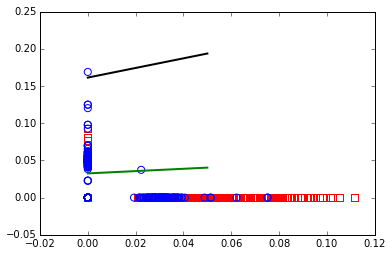

In [58]:
x1_line = np.linspace(0, 0.05)
a0b = (a0 # Is the factor of 1/2 real or a coincidence?
      + tfidf_weighted.sum()
      - tfidf_weighted[phrase1_index]
      - tfidf_weighted[phrase2_index])
# print (a0, tfidf_weighted.sum(), tfidf_weighted[phrase1_index], tfidf_weighted[phrase2_index])
# # a0b = -0.15 # -0.2 is pretty good
# a0b = -0.2
x2_line = -(a0b + a1*x1_line) / a2
x2_line_2d = -(a0_2d + a1_2d*x1_line) / a2_2d
# # m = np.array(['s', 'o']
plt.plot(x1_line, x2_line, 'k', lw=2)
plt.plot(x1_line, x2_line_2d, 'g', lw=2)
# # plt.scatter(x1, x2, c='blue', marker='o', s=50.*(y_predict_train))
# # plt.scatter(x1, x2, c='red', marker='s', s=50.*(1-y_predict_train))
plt.scatter(x1[y_train==1],
            x2[y_train==1],
            facecolor='None',
            edgecolor='red',
            marker='s', s=50)
plt.scatter(x1[y_train==0],
            x2[y_train==0],
            facecolor='None',
            edgecolor='blue',
            marker='o', s=50)

# plt.scatter(x1, x2, c='red', marker='s', s=50.*(1-y_test))
# plt.xlabel(phrase1)
# plt.ylabel(phrase2)

In [18]:
print a0 + 2* tfidf_weighted.sum()

-1.15929490665


In [19]:
myclf = clf.named_steps['clf']
print myclf.intercept_
print myclf.classes_
print myclf.coef_.argsort()[:, ::-1]

[ 1.90285638]
[0 1]
[[268994 317942 181293 ..., 258912 163588 163723]]


In [20]:
clf.named_steps['vect'].get_feature_names()[4445]
myclf.coef_[0,2772]

0.0